In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

from etl_data_Igor import spine_dataset
from models import ImprovedAttentionUNet

In [2]:
data = spine_dataset()

/home/igor-lechoszest/anaconda3/envs/AI_Diag/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Klasy w masce: [0 1 2 3]


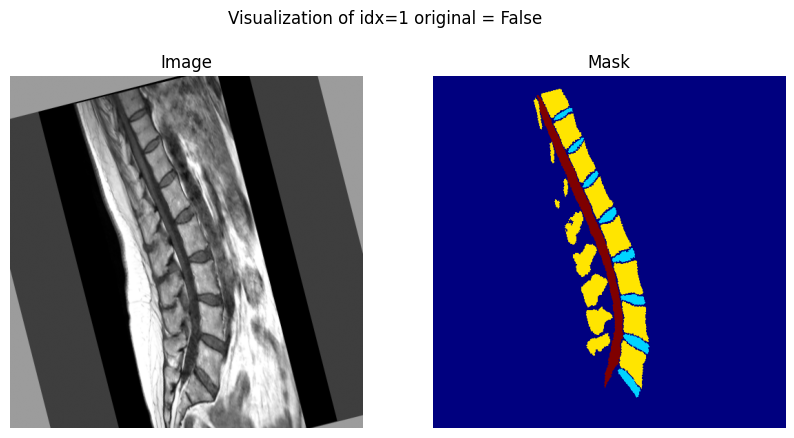

Klasy w masce: [0 1 2 3]


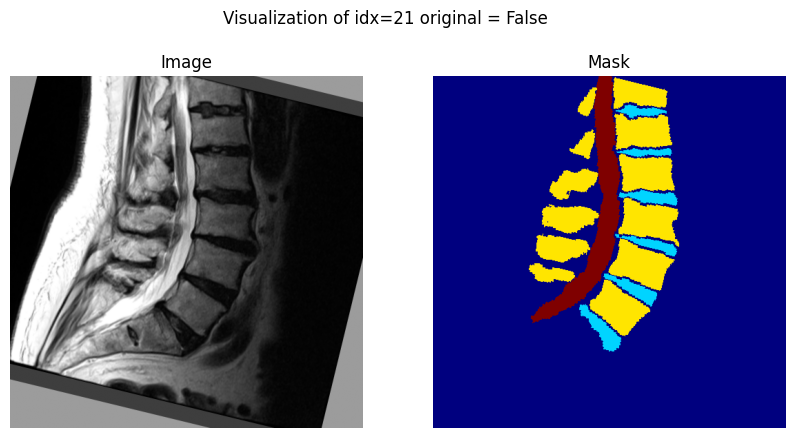

Klasy w masce: [0 1 2 3]


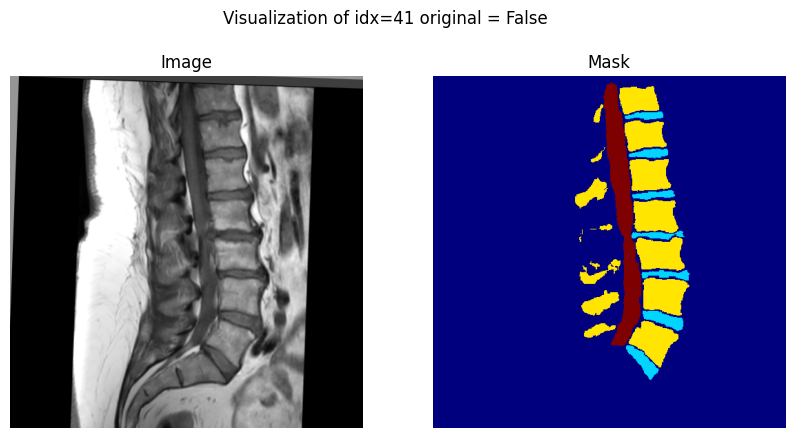

Klasy w masce: [0 1 2 3]


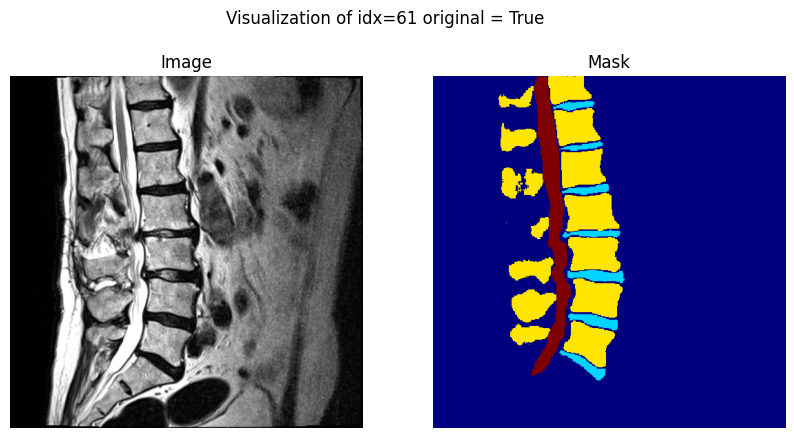

Klasy w masce: [0 1 2 3]


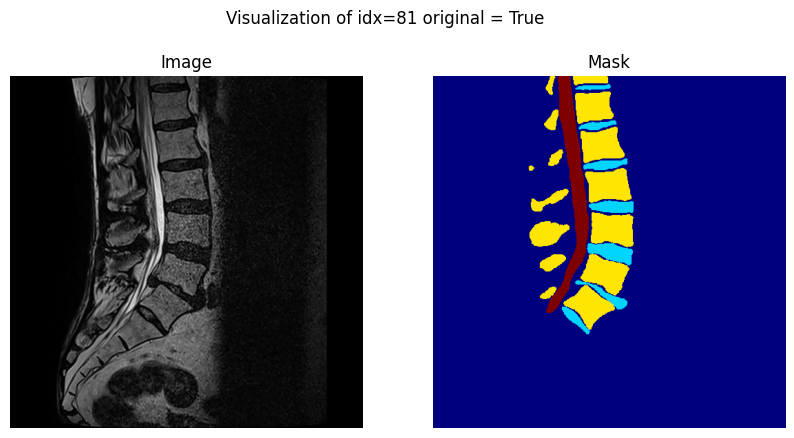

Klasy w masce: [0 1 2 3]


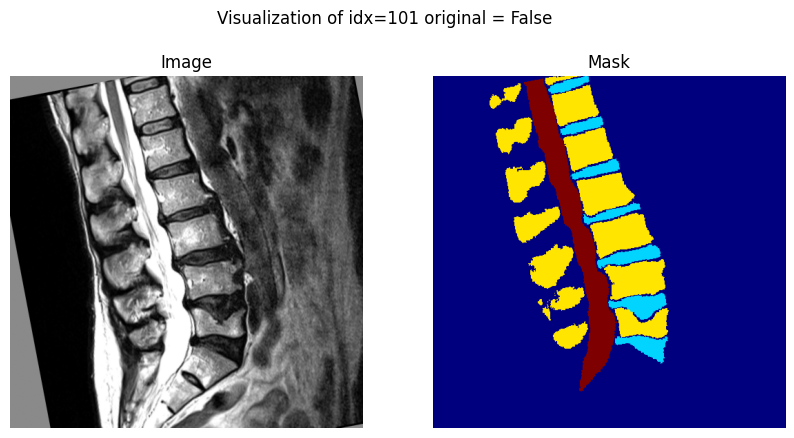

Klasy w masce: [0 1 2 3]


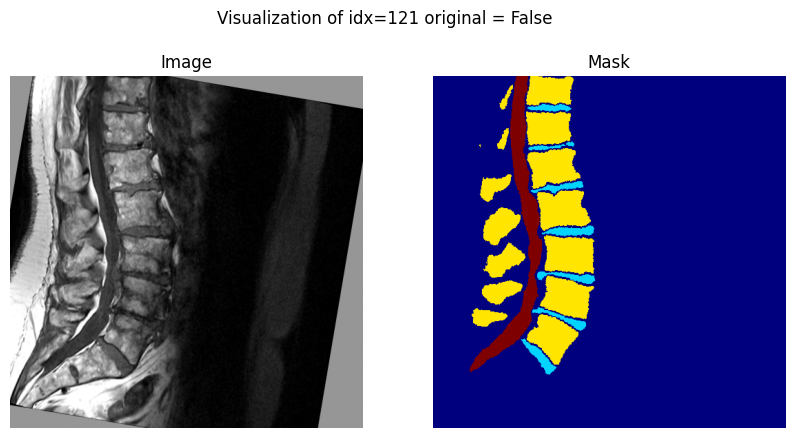

Klasy w masce: [0 1 2 3]


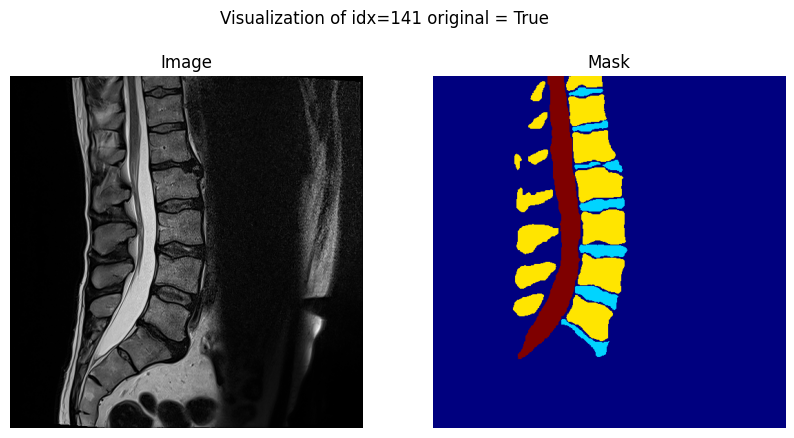

Klasy w masce: [0 1 2 3]


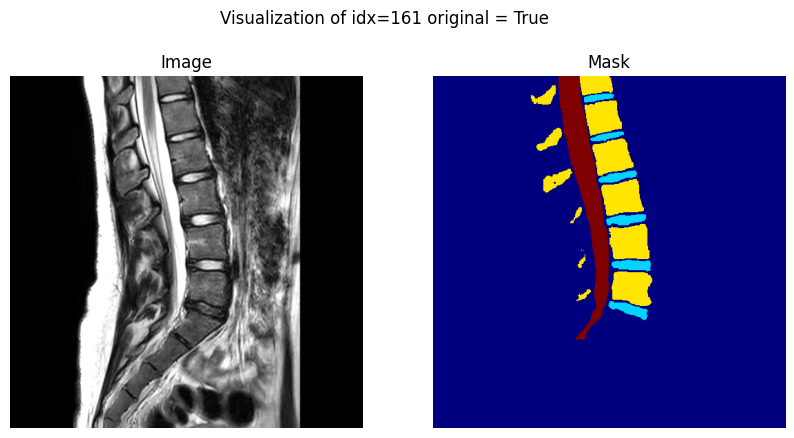

Klasy w masce: [0 1 2 3]


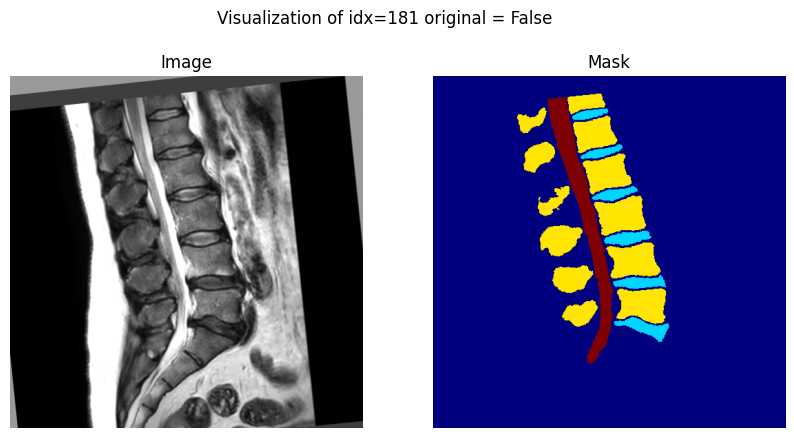

In [4]:
for i in range(1, 200, 20):
    data.visualize(i)

In [3]:
print(len(data))

4082


# Trening modelu

Używam GPU (CUDA)
Wczytywanie i dzielenie danych...


/home/igor-lechoszest/anaconda3/envs/AI_Diag/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Dane podzielone:
  -> Trening:   2842 (70%)
  -> Walidacja: 812 (20%)
  -> Test:      407 (10%)
Rozpoczynam trening...
Epoka [1/10] | Train Loss: 0.3661 | Val Loss: 0.2779
Epoka [2/10] | Train Loss: 0.2121 | Val Loss: 0.2150
Epoka [3/10] | Train Loss: 0.1909 | Val Loss: 0.1840
Epoka [4/10] | Train Loss: 0.1801 | Val Loss: 0.1801
Epoka [5/10] | Train Loss: 0.1746 | Val Loss: 0.1910
Epoka [6/10] | Train Loss: 0.1669 | Val Loss: 0.1671
Epoka [7/10] | Train Loss: 0.1607 | Val Loss: 0.1697
Epoka [8/10] | Train Loss: 0.1648 | Val Loss: 0.1672
Epoka [9/10] | Train Loss: 0.1537 | Val Loss: 0.1609
Epoka [10/10] | Train Loss: 0.1558 | Val Loss: 0.1624

Trening zakończony. Wczytuję najlepszy model do testów...

--- ROZPOCZYNAM TESTOWANIE NA ZBIORZE TESTOWYM (10%) ---

=== WYNIKI TESTU (DICE SCORE) ===
Klasa                | Dice Score
-----------------------------------
Tło                  | 0.9930
Kręgi                | 0.9177
Dyski                | 0.9496
Sacrum               | 0.9475
--------

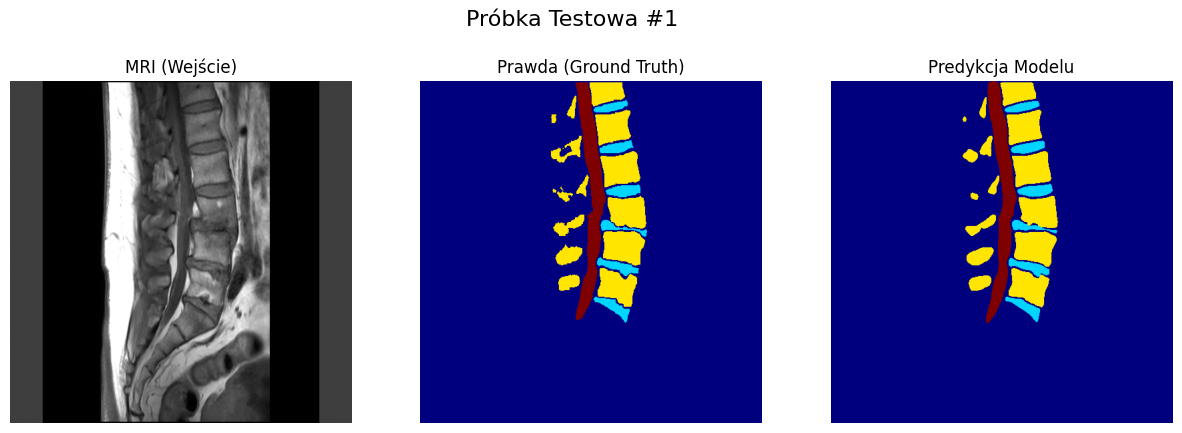

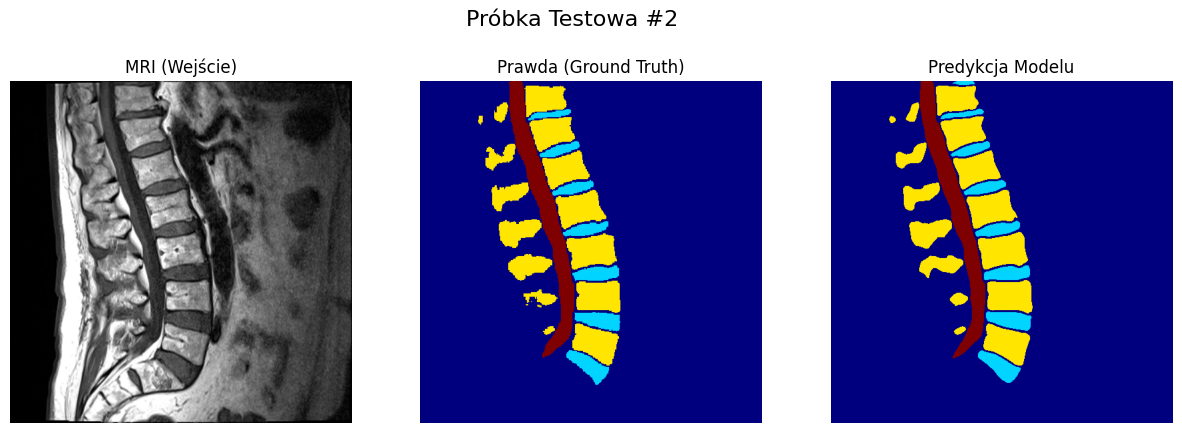

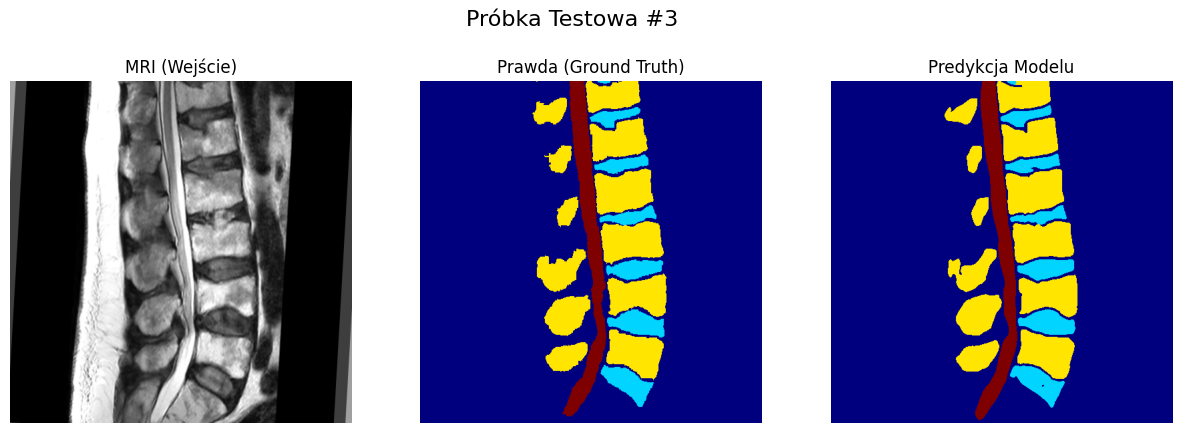

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import random
from models import HybridLoss

def evaluate_on_test_set(model, test_loader, device, num_classes=4):
    """
    Funkcja pomocnicza: Oblicza metryki i wizualizuje wyniki na zbiorze testowym.
    """
    model.eval()
    dice_scores = torch.zeros(num_classes).to(device)
    class_counts = torch.zeros(num_classes).to(device)
    class_names = ["Tło", "Kręgi", "Dyski", "Sacrum"]
    
    # Zbieramy próbki do wizualizacji
    visual_samples = []
    
    print("\n--- ROZPOCZYNAM TESTOWANIE NA ZBIORZE TESTOWYM (10%) ---")
    
    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(test_loader):
            images = images.to(device, dtype=torch.float32)
            masks = masks.to(device, dtype=torch.long)
            
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            
            # 1. Obliczanie Dice Score
            for cls in range(num_classes):
                pred_inds = (preds == cls)
                target_inds = (masks == cls)
                
                if target_inds.sum() > 0: # Liczymy tylko jeśli klasa istnieje w obrazie
                    intersection = (pred_inds & target_inds).float().sum()
                    union = pred_inds.float().sum() + target_inds.float().sum()
                    dice = (2. * intersection) / (union + 1e-8)
                    dice_scores[cls] += dice
                    class_counts[cls] += 1
            
            # 2. Zapisywanie kilku próbek do późniejszego wyświetlenia
            # Bierzemy pierwszy obraz z każdego batcha, aż uzbieramy np. 3 sztuki
            if len(visual_samples) < 3:
                img_np = images[0, 0].cpu().numpy() # (H, W)
                mask_true_np = masks[0].cpu().numpy()
                mask_pred_np = preds[0].cpu().numpy()
                visual_samples.append((img_np, mask_true_np, mask_pred_np))

    # --- RAPORT WYNIKÓW ---
    avg_dice = dice_scores / (class_counts + 1e-8)
    
    print("\n=== WYNIKI TESTU (DICE SCORE) ===")
    print(f"{'Klasa':<20} | {'Dice Score':<10}")
    print("-" * 35)
    for i in range(num_classes):
        print(f"{class_names[i]:<20} | {avg_dice[i].item():.4f}")
    print("-" * 35)
    print(f"Średni Dice (bez tła): {avg_dice[1:].mean().item():.4f}")
    
    # --- WIZUALIZACJA ---
    print("\nWyświetlam przykłady ze zbioru testowego...")
    for i, (img, true_m, pred_m) in enumerate(visual_samples):
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle(f'Próbka Testowa #{i+1}', fontsize=16)
        
        ax[0].imshow(img, cmap='gray')
        ax[0].set_title("MRI (Wejście)")
        ax[0].axis('off')
        
        ax[1].imshow(true_m, cmap='jet', vmin=0, vmax=3)
        ax[1].set_title("Prawda (Ground Truth)")
        ax[1].axis('off')
        
        ax[2].imshow(pred_m, cmap='jet', vmin=0, vmax=3)
        ax[2].set_title(f"Predykcja Modelu")
        ax[2].axis('off')
        
        plt.show()

def train_evaluate_and_test():
    # 1. Konfiguracja
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print("Używam GPU (CUDA)")
    elif torch.backends.mps.is_available():
        device = torch.device('mps')
        print("Używam GPU (Apple Metal)")
    else:
        device = torch.device('cpu')
        print("Używam CPU")

    # 2. Dataset i Podział (70% / 20% / 10%)
    print("Wczytywanie i dzielenie danych...")
    full_dataset = spine_dataset(if_trasform=True)
    
    total_len = len(full_dataset)
    train_len = int(0.7 * total_len)
    val_len = int(0.2 * total_len)
    test_len = total_len - train_len - val_len
    
    # Random split na 3 części
    train_ds, val_ds, test_ds = random_split(full_dataset, [train_len, val_len, test_len])
    
    print(f"Dane podzielone:")
    print(f"  -> Trening:   {len(train_ds)} (70%)")
    print(f"  -> Walidacja: {len(val_ds)} (20%)")
    print(f"  -> Test:      {len(test_ds)} (10%)")

    # DataLoader'y
    batch_size = 4
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=0) # Batch 1 dla testu jest wygodniejszy

    # 3. Model i Trening
    num_classes = 4
    model = ImprovedAttentionUNet(img_ch=1, output_ch=num_classes).to(device)
    criterion = HybridLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
    num_epochs = 10 # Możesz zmienić na więcej
    best_val_loss = float('inf')
    
    print("Rozpoczynam trening...")
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        
        for images, masks in train_loader:
            images = images.to(device, dtype=torch.float32)
            masks = masks.to(device, dtype=torch.long)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
        avg_train_loss = train_loss / len(train_loader)
        
        # Walidacja
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device, dtype=torch.float32)
                masks = masks.to(device, dtype=torch.long)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        
        print(f"Epoka [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
        
        # Zapisujemy najlepszy model (żeby testować najlepszą wersję, a nie ostatnią)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "best_spine_model.pth")

    print("\nTrening zakończony. Wczytuję najlepszy model do testów...")
    
    # 4. Wczytanie najlepszego modelu i TESTOWANIE
    model.load_state_dict(torch.load("best_spine_model.pth"))
    
    # Uruchomienie funkcji testującej i wizualizującej
    evaluate_on_test_set(model, test_loader, device, num_classes)

    return model

if __name__ == "__main__":
    try:
        train_evaluate_and_test()
    except Exception as e:
        print(f"Błąd: {e}")

# Kod do puszczania już zapisanego modelu

In [2]:
 # 4. Wczytanie najlepszego modelu i TESTOWANIE
full_dataset = spine_dataset(if_trasform=True)
    
total_len = len(full_dataset)
train_len = int(0.7 * total_len)
val_len = int(0.2 * total_len)
test_len = total_len - train_len - val_len
    
    # Random split na 3 części
train_ds, val_ds, test_ds = random_split(full_dataset, [train_len, val_len, test_len])
    
print(f"Dane podzielone:")
print(f"  -> Trening:   {len(train_ds)} (70%)")
print(f"  -> Walidacja: {len(val_ds)} (20%)")
print(f"  -> Test:      {len(test_ds)} (10%)")

    # DataLoader'y
batch_size = 4
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=0) # Batch 1 dla testu jest wygodniejszy


/home/igor-lechoszest/anaconda3/envs/AI_Diag/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Dane podzielone:
  -> Trening:   2850 (70%)
  -> Walidacja: 814 (20%)
  -> Test:      408 (10%)



--- ROZPOCZYNAM TESTOWANIE NA ZBIORZE TESTOWYM (10%) ---

=== WYNIKI TESTU (DICE SCORE) ===
Klasa                | Dice Score
-----------------------------------
Tło                  | 0.9933
Kręgi                | 0.9160
Dyski                | 0.9495
Sacrum               | 0.9488
-----------------------------------
Średni Dice (bez tła): 0.9381

Wyświetlam przykłady ze zbioru testowego...


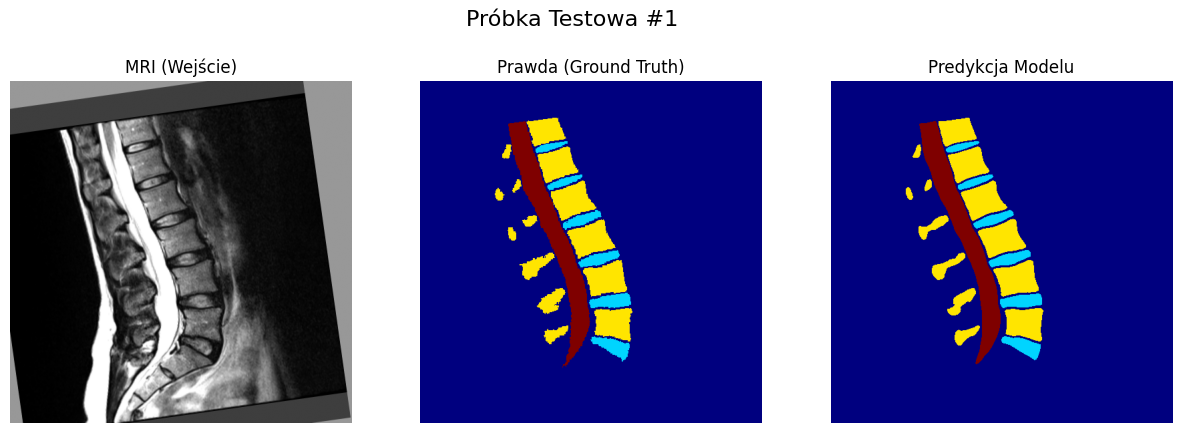

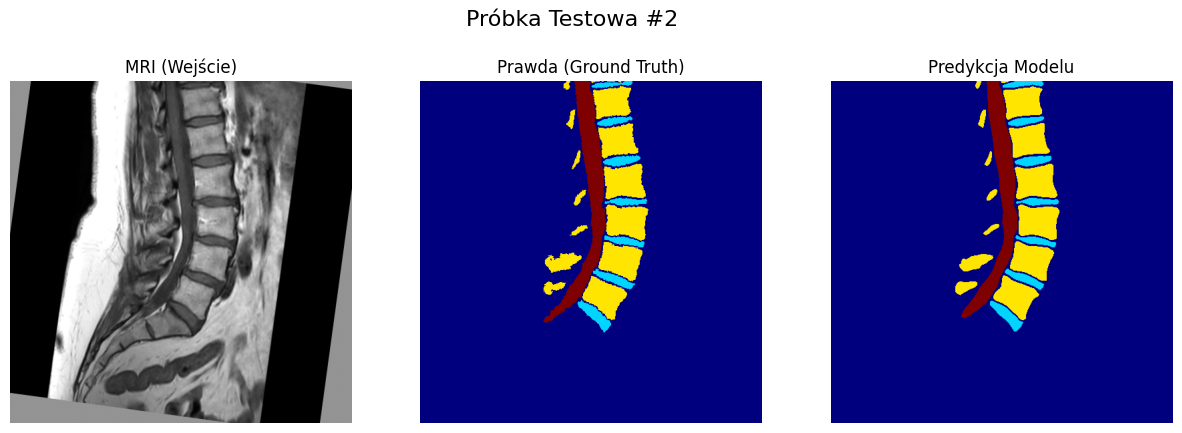

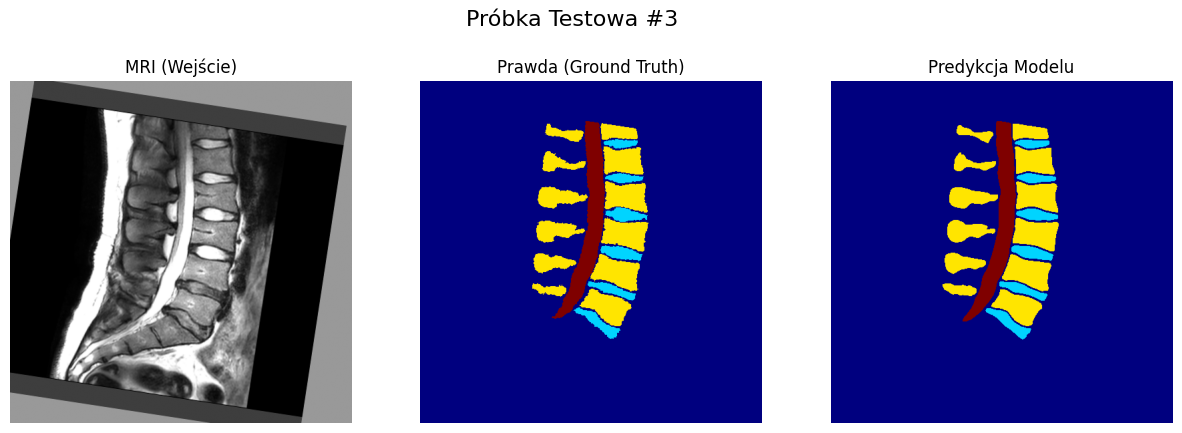

In [8]:
model = ImprovedAttentionUNet(img_ch=1, output_ch=4).to('cuda')
model.load_state_dict(torch.load("best_spine_model.pth"))
    
    # Uruchomienie funkcji testującej i wizualizującej
evaluate_on_test_set(model, test_loader, 'cuda', 4)